# Tutorial: Controlled Stream Generation

We will generate words and a Lexicon with minimal feature overlap between the words. Next, we introduce the 3 main ways to generate random streams, depending on how the transition probabilities (TPs) of their syllables are structured: word-structured TPs, fully random (uniform) TPs, and position-controlled TPs.

First, we generate/reload the words register (see arc types tutorial).

## Syllable and Word Generation

In [2]:
from arc import load_phonemes, make_syllables, make_words

print("Load phonemes...")
phonemes = load_phonemes()
print(phonemes)

print("Make syllables...")
syllables = make_syllables(phonemes, phoneme_pattern="cV", unigram_control=True, language_control=True, language_alpha=0.05)
print(syllables)

print("Make words...")
words = make_words(syllables)
print(words)

print("Save words ...")
words.save("words.json")

Load phonemes...
k͡p|ɡ͡b|c|ɡ|k|q|ɖ|ɟ|ɠ|ɢ|... (5275 elements total)
Make syllables...
ɡaː|ɡiː|ɡyː|ɡɛː|kaː|koː|kuː|køː|kɛː|baː|... (76 elements total)
Make words...


100%|██████████| 10000/10000 [00:08<00:00, 278.02it/s]

bigram control...
trigram control...
positional control...


100%|██████████| 10000/10000 [00:18<00:00, 545.58it/s]


heːtuːfoː|heːfaːtɛː|laːkuːfoː|deːfoːhøː|laːfoːkuː|tiːfaːhøː|kuːraːfyː|tyːhiːvaː|tiːfyːhøː|foːhiːtuː|... (1793 elements total)
Save words ...


## Lexicon Generation

Now we generate lexica with minimal feature repetitiveness. Let's start with 4 words each. 

By default, the function will generate 5 `Lexicon`s max. Let's generate 2 and print some info.

In [3]:
from arc import make_lexicons, load_words

words = load_words("words.json")

lexicons = make_lexicons(words, n_lexicons=2, n_words=4, control_features=True)

for lexicon in lexicons:
    print("Lexicon:", lexicon)
    print("cumulative_feature_repetitiveness:", lexicon.info["cumulative_feature_repetitiveness"])
    print("max_pairwise_feature_repetitiveness:", lexicon.info["max_pairwise_feature_repetitiveness"])
    print("")

Lexicon: høːtiːfoː|fyːroːɡɛː|koːfaːluː|zuːɡiːmyː
cumulative_feature_repetitiveness: 2
max_pairwise_feature_repetitiveness: 1

Lexicon: koːvaːlyː|peːhoːzɛː|reːɡiːfaː|fuːdoːhiː
cumulative_feature_repetitiveness: 2
max_pairwise_feature_repetitiveness: 1



By default, Lexicons with the minimum possible cumulative feature repetitiveness will be generated first, starting at zero. This means words will be joined into a lexicon if the features of all word pairs in the lexicon have no overlap. If it is not possible to generate the requested number Lexicons with the zero overlap, the allowed overlap will be incremented untill all lexicons are collecteed, which will be indicated by a warning message.

This process will be repeated, until any of the following statements is true
- the requested number of Lexicons has been generated
- the maximum allowed overlap is reached (set via `max_overlap`)
- the set of all word combinations is exhausted

If one or more Lexicons is returned, their info fields hold the cumulative overlap between all word pairs that is achieved by the Lexicon as well as the maximum pairwise overlap used.

## Stream Generation

We want to generate a complete set of compatible lexicons for our study, i.e. to generate a compatible set of streams for testing statistical learning hypotheses. If `streams` is empty, try increasing the allowed maximum rythmicity.

As you can see, the `.info` field holds some useful information about the generated stream, i.e. which Lexicon has been used to generate it, the rythmicity indexes achieved for each feature, and which randomization/TP-structure mode has been used.

The function `make_streams` will try to generate one stream for each lexicon and TP mode, and will discard those that do not meet the max_rhythmicity requirement. By default, all streams from a lexicon will be discarded if the lexicon can't generate streams for all requested TP modes.

In [4]:
def print_stream_info(stream):
    print("Stream:", "|".join([syll.id for syll in stream]))
    print("TP mode:", stream.info["stream_tp_mode"])
    print("Lexicon:", stream.info["lexicon"])
    print("Feature PRIs:", stream.info["rhythmicity_indexes"])
    print("")


In [5]:
from arc import make_streams
from arc import make_lexicons, load_words

words = load_words("words.json")
lexicons = make_lexicons(words, n_lexicons=20, n_words=4, control_features=True)
streams = make_streams(lexicons, max_rhythmicity=0.1, require_all_tp_modes=True)

for stream in streams:
    print_stream_info(stream)

print("Num Streams: ", len(streams))

Stream: nyː|hiː|huː|heː|koː|faː|vaː|deː|tyː|foː|fyː|tuː|tyː|faː|fyː|koː|nyː|foː|huː|tuː|vaː|hiː|heː|deː|faː|foː|nyː|deː|huː|koː|tuː|hiː|fyː|heː|vaː|tyː|fyː|tyː|heː|hiː|deː|foː|vaː|tuː|koː|huː|nyː|faː|tyː|vaː|huː|fyː|faː|hiː|koː|heː|nyː|tuː|foː|deː|nyː|tyː|tuː|deː|koː|vaː|foː|heː|fyː|hiː|faː|huː|faː|nyː|heː|tuː|huː|hiː|vaː|fyː|foː|koː|tyː|deː|heː|foː|tuː|nyː|fyː|vaː|faː|koː|hiː|tyː|huː|deː|fyː|deː|vaː|nyː|koː|foː|faː|tuː|heː|huː|tyː|hiː|foː|hiː|nyː|huː|vaː|koː|deː|tuː|faː|heː|tyː|fyː|nyː|vaː|heː|faː|deː|hiː|tuː|fyː|huː|foː|tyː|koː|fyː|heː|tyː|nyː|foː|faː|deː|hiː|tuː|vaː|huː|koː|hiː|nyː|tyː|koː|faː|fyː|huː|foː|deː|tuː|heː|vaː|tyː|hiː|heː|foː|fyː|nyː|deː|vaː|tuː|koː|huː|faː|hiː|faː|foː|tyː|deː|huː|heː|tuː|nyː|fyː|koː|vaː|hiː|deː|tyː|vaː|nyː|huː|tuː|fyː|faː|heː|koː|foː|koː|nyː|heː|deː|foː|tuː|huː|hiː|fyː|vaː|faː|tyː|foː|vaː|deː|fyː|tuː|hiː|tyː|huː|nyː|faː|koː|heː|faː|huː|fyː|foː|heː|nyː|hiː|vaː|koː|tyː|tuː|deː|nyː|koː|tuː|tyː|heː|huː|deː|faː|vaː|fyː|hiː|foː|huː|tyː|faː|tuː|foː|hiː|koː|fyː|

# Compare Lexicons

In [6]:
N_LEXICONS = 21
N_WORDS_PER_LEXICON = 4
N_REPS = 5
N_STREAMS_PER_INPUT = 5

In [7]:
from arc import make_streams
from arc import make_lexicons, Register

from arc import load_phonemes, make_syllables, make_words, load_words

# should we make the generated lexicons more similar to the ones from the reference literature? E.g. by having the same phoneme pattern?
#print("Load phonemes...")
#phonemes = load_phonemes()
#new_phonemes = Register()
#for phoneme in phonemes:
#    if phoneme.id in ("a", "e", "i", "o", "u") and not phoneme.get_binary_feature("cons"):
#        new_phonemes.append(phoneme)
#    if phoneme.id in "bcdfghjklmnpqrstvwxyz" and phoneme.get_binary_feature("cons"):
#        new_phonemes.append(phoneme)
#phonemes = new_phonemes
#print(phonemes)
#print("")

#print("Make syllables...")
#syllables = make_syllables(phonemes, phoneme_pattern="cV", unigram_control=True, language_control=True)
#print(syllables)
#print("")

#print("Make words...")
#words = make_words(syllables, bigram_control=False, trigram_control=False)
#print(words)
#print("")

print("Load words...")
words = load_words("words.json")

print("Make lexicons...")
controlled_lexicons = make_lexicons(words, n_lexicons=N_LEXICONS, n_words=N_WORDS_PER_LEXICON, control_features=True)
for lexicon in controlled_lexicons:
    print("Lexicon:", lexicon)
    print("Info:", lexicon.info)
    print("")

controlled_streams = Register()
for _ in range(N_STREAMS_PER_INPUT):
    for stream in make_streams(
        controlled_lexicons, 
        max_rhythmicity=None, 
        num_repetitions=N_REPS
        ):
        controlled_streams.append(stream)

for stream in controlled_streams:
    print_stream_info(stream)

len(controlled_streams)

Load words...
Make lexicons...


Lexicon: reːfoːɡiː|kuːmoːzyː|vaːdeːhøː|ʃoːɡaːmeː
Info: {'phoneme_feature_labels': ['syl', 'son', 'cons', 'cont', 'delrel', 'lat', 'nas', 'strid', 'voi', 'sg', 'cg', 'ant', 'cor', 'distr', 'lab', 'hi', 'lo', 'back', 'round', 'tense', 'long'], 'syllable_feature_labels': [['son', 'back', 'hi', 'lab', 'cor', 'cont', 'lat', 'nas', 'voi'], ['back', 'hi', 'lo', 'lab', 'tense', 'long']], 'syllable_type': 'cV', 'bigram_pval': None, 'bigrams_count': 1473, 'trigram_pval': None, 'trigrams_count': 21266, 'cumulative_feature_repetitiveness': 2, 'max_pairwise_feature_repetitiveness': 1}

Lexicon: faːhiːdoː|reːfoːɡiː|koːzyːmuː|zuːhoːpaː
Info: {'phoneme_feature_labels': ['syl', 'son', 'cons', 'cont', 'delrel', 'lat', 'nas', 'strid', 'voi', 'sg', 'cg', 'ant', 'cor', 'distr', 'lab', 'hi', 'lo', 'back', 'round', 'tense', 'long'], 'syllable_feature_labels': [['son', 'back', 'hi', 'lab', 'cor', 'cont', 'lat', 'nas', 'voi'], ['back', 'hi', 'lo', 'lab', 'tense', 'long']], 'syllable_type': 'cV', 'bigram_pval':

315

... vs. streams based on random / uncontrolled lexicons (baseline)...

In [8]:
random_lexicons = make_lexicons(words, n_lexicons=N_LEXICONS, n_words=N_WORDS_PER_LEXICON, control_features=False)
for lexicon in random_lexicons:
    print("Lexicon:", lexicon)
    print("Info:", lexicon.info)
    print("")

random_streams = Register()
for _ in range(N_STREAMS_PER_INPUT):
    for stream in make_streams(
        random_lexicons, 
        max_rhythmicity=None, 
        num_repetitions=N_REPS
        ):
        random_streams.append(stream)
for stream in random_streams:
    print_stream_info(stream)

len(random_streams)

Lexicon: kuːfoːnɛː|biːhoːʃuː|vaːkoːnøː|koːfaːnøː
Info: {'phoneme_feature_labels': ['syl', 'son', 'cons', 'cont', 'delrel', 'lat', 'nas', 'strid', 'voi', 'sg', 'cg', 'ant', 'cor', 'distr', 'lab', 'hi', 'lo', 'back', 'round', 'tense', 'long'], 'syllable_feature_labels': [['son', 'back', 'hi', 'lab', 'cor', 'cont', 'lat', 'nas', 'voi'], ['back', 'hi', 'lo', 'lab', 'tense', 'long']], 'syllable_type': 'cV', 'bigram_pval': None, 'bigrams_count': 1473, 'trigram_pval': None, 'trigrams_count': 21266}

Lexicon: fiːkoːruː|fyːraːkɛː|huːvaːtɛː|kuːfiːloː
Info: {'phoneme_feature_labels': ['syl', 'son', 'cons', 'cont', 'delrel', 'lat', 'nas', 'strid', 'voi', 'sg', 'cg', 'ant', 'cor', 'distr', 'lab', 'hi', 'lo', 'back', 'round', 'tense', 'long'], 'syllable_feature_labels': [['son', 'back', 'hi', 'lab', 'cor', 'cont', 'lat', 'nas', 'voi'], ['back', 'hi', 'lo', 'lab', 'tense', 'long']], 'syllable_type': 'cV', 'bigram_pval': None, 'bigrams_count': 1473, 'trigram_pval': None, 'trigrams_count': 21266}

Lexi

315

...vs reference lexicons from the literature.

In [9]:
from copy import copy
import pandas as pd
import numpy as np

from arc.core.syllable import LABELS_C, LABELS_V, syllable_from_phonemes
from arc.core.word import Word, word_overlap_matrix

phoneme_register = load_phonemes()

df = pd.read_excel("../docs/titone_table_references_algorithm.xlsx")

syll_feature_labels = [LABELS_C, LABELS_V]
syllable_type = "cv"

lexicons = [[['pi', 'ɾu', 'ta'],
  ['ba', 'ɡo', 'li'],
  ['to', 'ku', 'da'],
  ['ɡu', 'ki', 'bo']],
 [['pa', 'be', 'la'],
  ['di', 'ne', 'ka'],
  ['lu', 'fa', 'ri'],
  ['xi', 'so', 'du']],
 [['ma', 'xu', 'pe'],
  ['xe', 'ro', 'ɡa'],
  ['de', 'mu', 'si'],
  ['fo', 'le', 'ti']],
 [['pu', 'ke', 'mi'],
  ['ra', 'fi', 'nu'],
  ['bi', 'na', 'po'],
  ['me', 'do', 'xi']],
 [['no', 'ni', 'xe'],
  ['bu', 'lo', 'te'],
  ['re', 'mo', 'fu'],
  ['ko', 'tu', 'sa']],
 [['mi', 'lo', 'de'],
  ['da', 'le', 'bu'],
  ['no', 'ru', 'pa'],
  ['ka', 'te', 'xi']],
 [['ne', 'do', 'li'],
  ['ri', 'fo', 'nu'],
  ['ba', 'to', 'ɡu'],
  ['ki', 'ra', 'pu']],
 [['ɡo', 'na', 'be'],
  ['mu', 'di', 'la'],
  ['ro', 'ni', 'xe'],
  ['pi', 'ku', 'sa']],
 [['fu', 'bi', 're'],
  ['xe', 'tu', 'si'],
  ['ta', 'fi', 'ko'],
  ['ke', 'ma', 'po']],
 [['ti', 'fa', 'xu'],
  ['so', 'du', 'xi'],
  ['me', 'lu', 'bo'],
  ['ɡa', 'ni', 'pe']],
 [['mi', 'po', 'la'],
  ['za', 'bɛ', 'tu'],
  ['ʁo', 'ki', 'sɛ'],
  ['nu', 'ɡa', 'di']],
 [['dɛ', 'mʊ', 'ri'],
  ['sɛ', 'ni', 'ɡɛ'],
  ['ræ', 'ku', 'səʊ'],
  ['pi', 'lɛ', 'ru']],
 [['ki', 'fəʊ', 'bu'],
  ['lu', 'fɑ', 'ɡi'],
  ['pæ', 'beɪ', 'lɑ'],
  ['tɑ', 'ɡəʊ', 'fʊ']],
 [['bi', 'du', 'pɛ'],
  ['məʊ', 'bɑ', 'li'],
  ['rɛ', 'ɡæ', 'tʊ'],
  ['sæ', 'tɛ', 'kəʊ']],
 [['bəʊ', 'dɑ', 'mɛ'],
  ['fi', 'nəʊ', 'pɑ'],
  ['ɡʊ', 'rɑ', 'təʊ'],
  ['ləʊ', 'kæ', 'neɪ']],
 [['fɛ', 'si', 'nɑ'],
  ['kɛ', 'su', 'dəʊ'],
  ['mæ', 'pʊ', 'di'],
  ['ti', 'mi', 'nu']],
 [['tu', 'pi', 'ɹoʊ'],
  ['ɡoʊ', 'la', 'bu'],
  ['pa', 'doʊ', 'ti'],
  ['bi', 'da', 'ku']],
 [['meɪ', 'lu', 'ɡi'],
  ['ɹa', 'fi', 'nu'],
  ['pu', 'keɪ', 'mi'],
  ['toʊ', 'na', 'poʊ']],
 [['ɡoʊ', 'la', 'tu'],
  ['da', 'ɹoʊ', 'pi'],
  ['ti', 'bu', 'doʊ'],
  ['pa', 'bi', 'ku']],
 [['poʊ', 'fi', 'mu'],
  ['noʊ', 'vu', 'ka'],
  ['vi', 'koʊ', 'ɡa'],
  ['ba', 'fu', 'ɡi']],
 [['ma', 'nu', 'toʊ'],
  ['ni', 'moʊ', 'lu'],
  ['voʊ', 'ɹi', 'fa'],
  ['li', 'du', 'ɹa']]]

def to_phoneme(phoneme):
    return phoneme

def to_syllable(syllable):
    if len(syllable) == 3:
        syllable_obj = syllable_from_phonemes(phonemes, syllable[:3], syll_feature_labels)
        syllable_obj.id = syllable
        return syllable_obj
    return syllable_from_phonemes(phonemes, syllable[:3], syll_feature_labels)

def to_word(word):
    syllables_list = list(map(to_syllable, word))
    word_id = "".join(s.id for s in syllables_list)
    word_features = list(list(tup) for tup in zip(*[s.info["binary_features"] for s in syllables_list]))
    return Word(id=word_id, info={"binary_features": word_features}, syllables=syllables_list)

def to_lexicon(lexicon):
    word_objs_list = list(map(to_word, lexicon))
    lexicon = Register({w.id:  w for w in word_objs_list})
    lexicon.info.update({"syllable_feature_labels": [LABELS_C, LABELS_V],  "syllable_type": syllable_type})
    overlap = word_overlap_matrix(lexicon)
    lexicon.info["cumulative_feature_repetitiveness"] = np.triu(overlap,1).sum()
    lexicon.info["max_pairwise_feature_repetitiveness"] = np.triu(overlap,1).max()
    return lexicon

ref_lexicons = list(map(to_lexicon, lexicons))

for lex in ref_lexicons:
    print(lex)

piɾuta|baɡoli|tokuda|ɡukibo
pabela|dineka|lufari|xisodu
maxupe|xeroɡa|demusi|foleti
pukemi|rafinu|binapo|medoxi
nonixe|bulote|remofu|kotusa
milode|dalebu|norupa|katexi
nedoli|rifonu|batoɡu|kirapu
ɡonabe|mudila|ronixe|pikusa
fubire|xetusi|tafiko|kemapo
tifaxu|soduxi|melubo|ɡanipe
mipola|zabɛtu|ʁokisɛ|nuɡadi
dɛmʊri|sɛniɡɛ|rækusəʊ|pilɛru
kifəʊbu|lufɑɡi|pæbeɪlɑ|tɑɡəʊfʊ
bidupɛ|məʊbɑli|rɛɡætʊ|sætɛkəʊ
bəʊdɑmɛ|finəʊpɑ|ɡʊrɑtəʊ|ləʊkæneɪ
fɛsinɑ|kɛsudəʊ|mæpʊdi|timinu
tupiɹoʊ|ɡoʊlabu|padoʊti|bidaku
meɪluɡi|ɹafinu|pukeɪmi|toʊnapoʊ
ɡoʊlatu|daɹoʊpi|tibudoʊ|pabiku
poʊfimu|noʊvuka|vikoʊɡa|bafuɡi
manutoʊ|nimoʊlu|voʊɹifa|liduɹa


In [10]:
ref_streams = Register()
for _ in range(N_STREAMS_PER_INPUT):
    for stream in make_streams(
        ref_lexicons, 
        max_rhythmicity=None, 
        num_repetitions=N_REPS
        ):
        ref_streams.append(stream)

for stream in ref_streams:
    print_stream_info(stream)

len(ref_streams)

Stream: pi|ɡo|ki|da|ba|ɾu|ta|li|ɡu|ku|to|bo|ki|pi|da|ɾu|bo|ta|ɡo|ɡu|to|ba|ku|li|bo|da|ku|ɡu|ki|ɡo|li|ta|ba|to|ɾu|pi|li|da|pi|ɡu|bo|ba|ki|ta|ku|ɾu|to|ɡo|ba|ɡu|ta|pi|ki|bo|ku|ɡo|to|da|li|ɾu|ɡo|ɾu|ki|to|ku|da|ta|ɡu|li|pi|ba|bo|ɡu|pi|to|li|ɡo|da|bo|ɾu|ku|ta|ki|ba|ɡo|bo|pi|ɾu|li|ki|ku|ba|ta|to|ɡu|da|ki|li|to|pi|ku|bo|ɡo|ta|ɾu|ba|da|ɡu|ɾu|da|ɡo|ku|pi|ta|bo|to|ki|ɡu|ba|li|ba|pi|bo|li|ku|ki|ɾu|ɡu|ɡo|da|to|ta|da|ta|ɡu|to|bo|li|ki|ɾu|ku|ba|ɡo|pi|bo|ki|ba|ta|to|ɾu|da|li|ɡu|ku|ɡo|pi|ɡu|bo|ɡo|li|ba|ɾu|ta|pi|ku|to|ki|da|ɡo|ku|ɡu|ki|ta|li|bo|da|ba|pi|ɾu|to|li|to|ɡu|pi|ba|da|bo|ta|ɡo|ɾu|ki|ku|ta|ku|ki|ɡo|ɡu|li|da|ɾu|bo|ba|to|pi|ki|li|ta|da|pi|to|ku|bo|ɾu|ɡu|ɡo|ba|li|ku|da|to|ta|ba|ki|pi|ɡo|bo|ɡu|ɾu|ɡo|ki|bo|to|da|ɡu|ba|ku|li|ɾu|pi|ta|bo|ku|pi|da|ki|to|ba|ɡu|ta|ɾu|li|ɡo|ta|ki|ɡu|da|ku|ɾu|ba|bo|pi|li|ɡo|to|ɡo|ba|ki|ku|da|bo|ɡu|ɾu|li|pi|to|ta|to|ɾu|ku|pi|da|ki|ta|ɡo|li|ɡu|bo|ba|ku|li|da|to|ba|ɡu|ki|bo|pi|ɡo|ta|ɾu|bo|to|ku|ki|li|ba|ɾu|da|ɡo|pi|ta|ɡu|ku|ɡo|bo|ta|pi|ki|ɡu|ba|da|li|ɾu|to|bo|da|ku|to|ɡu|li|pi

315

In [19]:
import pandas as pd

data = {"Control": [], "Lexicon": [], "Feature": [], "PRI": [], "Stream TP mode": [], "Stream": []}

mode_to_mode = {  # TP-random position-random; TP-random position-fixed and TP-structured
    "random": "TP-random position-random",
    "word_structured": "TP-structured",
    "position_controlled": "TP-random position-fixed"
}

for control, streams in [("Controlled lexicons (ARC)", controlled_streams), ("Reference lexicons (Literature)", ref_streams), ("Random lexicons (Baseline)", random_streams)]:
    for stream in streams:
        for k, v in stream.info["rhythmicity_indexes"].items():
            data["Feature"].append(k)
            data["PRI"].append(v)
            data["Control"].append(control)
            data["Lexicon"].append(str(stream.info["lexicon"]))
            data["Stream TP mode"].append(mode_to_mode[stream.info["stream_tp_mode"]])
            data["Stream"].append("|".join(syll.id for syll in stream))
        data["Feature"].append("max")
        data["PRI"].append(max(stream.info["rhythmicity_indexes"].values()))
        data["Control"].append(control)
        data["Lexicon"].append(str(stream.info["lexicon"]))
        data["Stream TP mode"].append(mode_to_mode[stream.info["stream_tp_mode"]])
        data["Stream"].append("|".join(syll.id for syll in stream))

df = pd.DataFrame(data).sort_values(["Control", "Lexicon", "Stream TP mode"]).reset_index(drop=True)

df.to_csv("full_dataset.csv")

df

,Control,Lexicon,Feature,PRI,Stream TP mode,Stream
0,Controlled lexicons (ARC),faːhiːdoː|reːfoːɡiː|koːzyːmuː|zuːhoːpaː,phon_1_son,0.044818,TP-random position-fixed,koː|hiː|muː|faː|hoː|paː|reː|zyː|ɡiː|zuː|foː|do...
1,Controlled lexicons (ARC),faːhiːdoː|reːfoːɡiː|koːzyːmuː|zuːhoːpaː,phon_1_back,0.030812,TP-random position-fixed,koː|hiː|muː|faː|hoː|paː|reː|zyː|ɡiː|zuː|foː|do...
2,Controlled lexicons (ARC),faːhiːdoː|reːfoːɡiː|koːzyːmuː|zuːhoːpaː,phon_1_hi,0.030812,TP-random position-fixed,koː|hiː|muː|faː|hoː|paː|reː|zyː|ɡiː|zuː|foː|do...
3,Controlled lexicons (ARC),faːhiːdoː|reːfoːɡiː|koːzyːmuː|zuːhoːpaː,phon_1_lab,0.044818,TP-random position-fixed,koː|hiː|muː|faː|hoː|paː|reː|zyː|ɡiː|zuː|foː|do...
4,Controlled lexicons (ARC),faːhiːdoː|reːfoːɡiː|koːzyːmuː|zuːhoːpaː,phon_1_cor,0.054622,TP-random position-fixed,koː|hiː|muː|faː|hoː|paː|reː|zyː|ɡiː|zuː|foː|do...
...,...,...,...,...,...,...
15115,Reference lexicons (Literature),ɡoʊlatu|daɹoʊpi|tibudoʊ|pabiku,phon_2_lo,0.142857,TP-structured,pa|bi|ku|da|ɹoʊ|pi|ti|bu|doʊ|ɡoʊ|la|tu|ti|bu|d...
15116,Reference lexicons (Literature),ɡoʊlatu|daɹoʊpi|tibudoʊ|pabiku,phon_2_lab,0.144258,TP-structured,pa|bi|ku|da|ɹoʊ|pi|ti|bu|doʊ|ɡoʊ|la|tu|ti|bu|d...
15117,Reference lexicons (Literature),ɡoʊlatu|daɹoʊpi|tibudoʊ|pabiku,phon_2_tense,0.000000,TP-structured,pa|bi|ku|da|ɹoʊ|pi|ti|bu|doʊ|ɡoʊ|la|tu|ti|bu|d...
15118,Reference lexicons (Literature),ɡoʊlatu|daɹoʊpi|tibudoʊ|pabiku,phon_2_long,0.000000,TP-structured,pa|bi|ku|da|ɹoʊ|pi|ti|bu|doʊ|ɡoʊ|la|tu|ti|bu|d...


In [51]:
df_lexicons = df[["Control", "Lexicon"]].drop_duplicates().reset_index(drop=True)
df_lexicons.to_csv("all_lexicons.csv")
df_lexicons

,Control,Lexicon
0,Controlled lexicons (ARC),faːhiːdoː|reːfoːɡiː|koːzyːmuː|zuːhoːpaː
1,Controlled lexicons (ARC),faːhiːtuː|reːfoːɡiː|ʃoːɡaːmeː|hoːʃiːbeː
2,Controlled lexicons (ARC),hiːdeːfyː|bøːhuːʃoː|ʃuːheːbiː|ɡiːvaːreː
3,Controlled lexicons (ARC),hiːdeːfyː|kuːmoːzyː|foːryːɡiː|ʃoːɡaːmeː
4,Controlled lexicons (ARC),huːtoːfiː|vaːroːɡiː|kuːmoːzyː|ʃoːɡaːmeː
...,...,...
58,Reference lexicons (Literature),pukemi|rafinu|binapo|medoxi
59,Reference lexicons (Literature),tifaxu|soduxi|melubo|ɡanipe
60,Reference lexicons (Literature),tupiɹoʊ|ɡoʊlabu|padoʊti|bidaku
61,Reference lexicons (Literature),ɡonabe|mudila|ronixe|pikusa


## Stats

In [21]:
import matplotlib as mpl

mpl.rcParams["axes.titlesize"] = 14.
mpl.rcParams["axes.labelsize"] = 12.
mpl.rcParams["axes.titleweight"] = "bold"
mpl.rcParams["axes.labelweight"] = "normal"
mpl.rcParams['font.sans-serif'] = "Arial"
print(mpl.rcParams["axes.titlesize"])
print(mpl.rcParams["axes.labelsize"])
print(mpl.rcParams["axes.titleweight"])
print(mpl.rcParams["axes.labelweight"])
print(mpl.rcParams["lines.linewidth"])
print(mpl.rcParams["lines.markersize"])
print(mpl.rcParams["xtick.labelsize"])
print(mpl.rcParams["ytick.labelsize"])
print(mpl.rcParams['font.sans-serif'])
cm = 1/2.54  # centimeters in inches
for key in mpl.rcParams:
    if "axes" in key:
        print(key)

14.0
12.0
bold
normal
1.5
6.0
medium
medium
['Arial']
axes.autolimit_mode
axes.axisbelow
axes.edgecolor
axes.facecolor
axes.formatter.limits
axes.formatter.min_exponent
axes.formatter.offset_threshold
axes.formatter.use_locale
axes.formatter.use_mathtext
axes.formatter.useoffset
axes.grid
axes.grid.axis
axes.grid.which
axes.labelcolor
axes.labelpad
axes.labelsize
axes.labelweight
axes.linewidth
axes.prop_cycle
axes.spines.bottom
axes.spines.left
axes.spines.right
axes.spines.top
axes.titlecolor
axes.titlelocation
axes.titlepad
axes.titlesize
axes.titleweight
axes.titley
axes.unicode_minus
axes.xmargin
axes.ymargin
axes.zmargin
axes3d.grid
axes3d.xaxis.panecolor
axes3d.yaxis.panecolor
axes3d.zaxis.panecolor
legend.borderaxespad
polaraxes.grid


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
controlled vs. reference TP-random position-random,0.647384,208,less,7.409513e-01,"[-inf, 0.0]",0.089347,0.366,0.011007
controlled vs. reference TP-random position-fixed,-9.887044,208,less,1.925823e-19,"[-inf, -0.08]",1.364542,2.048e+16,1.000000
controlled vs. reference TP-structured,-8.007362,208,less,4.098562e-14,"[-inf, -0.08]",1.105121,1.447e+11,1.000000
controlled vs. random baseline TP-random position-random,-0.475413,208,less,3.174959e-01,"[-inf, 0.0]",0.065613,0.334,0.120802
controlled vs. random baseline TP-random position-fixed,-10.257320,208,less,1.533028e-20,"[-inf, -0.2]",1.415645,2.397e+17,1.000000
controlled vs. random baseline TP-structured,-15.383770,208,less,1.820283e-36,"[-inf, -0.28]",2.123162,9.548e+32,1.000000
reference vs. random baseline TP-random position-random,-1.059894,208,less,1.452111e-01,"[-inf, 0.0]",0.146279,0.509,0.278130
reference vs. random baseline TP-random position-fixed,-5.466880,208,less,6.523916e-08,"[-inf, -0.1]",0.754501,1.839e+05,0.999929
reference vs. random baseline TP-structured,-8.631946,208,less,7.873351e-16,"[-inf, -0.17]",1.191322,6.515e+12,1.000000


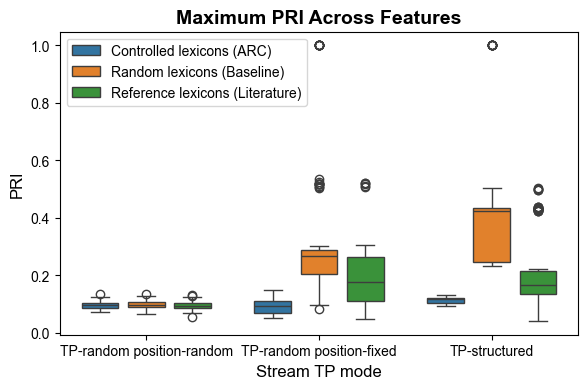

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from pingouin import ttest

tp_modes_pretty = ["TP-random position-random", "TP-random position-fixed", "TP-structured"]
dfs = []

for i, tp_mode in enumerate(tp_modes_pretty):
    df2 = df[(df["Stream TP mode"] == tp_mode) & (df["Feature"] == "max")]
    cat1 = df2[df2['Control']=='Controlled lexicons (ARC)']["PRI"]
    cat2 = df2[df2['Control']=='Reference lexicons (Literature)']["PRI"]
    this = ttest(list(cat1), list(cat2), alternative="less")
    this.index = [f"controlled vs. reference {tp_mode}"]
    dfs.append(this)

print("")

for i, tp_mode in enumerate(tp_modes_pretty):
    df2 = df[(df["Stream TP mode"] == tp_mode) & (df["Feature"] == "max")]
    cat1 = df2[df2['Control']=='Controlled lexicons (ARC)']["PRI"]
    cat2 = df2[df2['Control']=='Random lexicons (Baseline)']["PRI"]
    this = ttest(list(cat1), list(cat2), alternative="less")
    this.index = [f"controlled vs. random baseline {tp_mode}"]
    dfs.append(this)

print("")

for i, tp_mode in enumerate(tp_modes_pretty):
    df2 = df[(df["Stream TP mode"] == tp_mode) & (df["Feature"] == "max")]
    cat1 = df2[df2['Control']=='Reference lexicons (Literature)']["PRI"]
    cat2 = df2[df2['Control']=='Random lexicons (Baseline)']["PRI"]
    this = ttest(list(cat1), list(cat2), alternative="less")
    this.index = [f"reference vs. random baseline {tp_mode}"]
    dfs.append(this)

ttest_df = pd.concat(dfs)

display(ttest_df)

ttest_df.to_csv("ttest_results.csv")

_, ax = plt.subplots(figsize=(17*cm, 10*cm))
sns.boxplot(df[df["Feature"] == "max"], x="Stream TP mode", y="PRI", hue="Control", order=tp_modes_pretty, gap=0.2)
plt.title("Maximum PRI Across Features")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)

plt.savefig("lexicon_pris_summary.pdf", dpi=600)

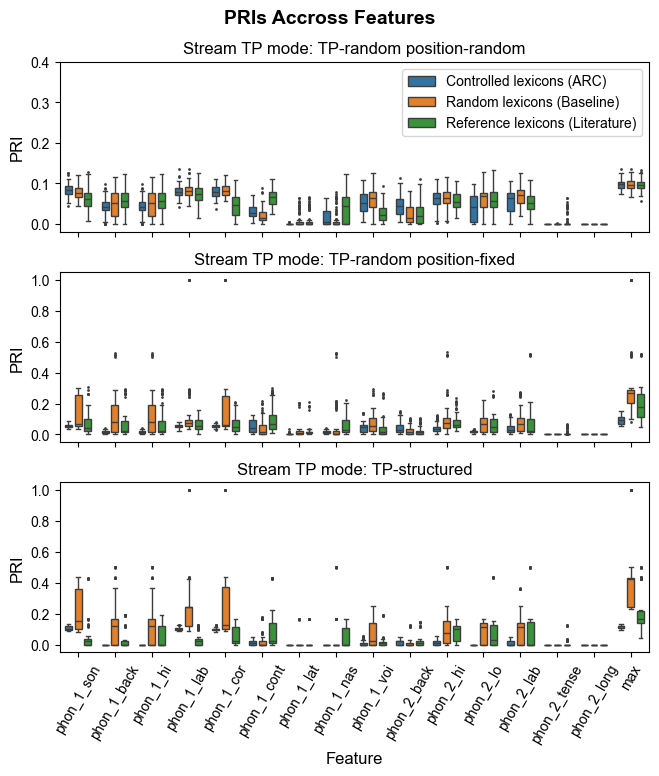

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

_, axs = plt.subplots(3, 1, figsize=(17*cm, 20*cm), layout="tight", sharex=True)
labels = ['Controlled\nlexicons (ARC)',
 'Reference\nlexicons (Literature)',
 'Random\nlexicons (Baseline)']

for i, tp_mode in enumerate(tp_modes_pretty):
    sns.boxplot(df[df["Stream TP mode"] == tp_mode], x="Feature", y="PRI", hue="Control", ax=axs[i], fliersize=1, gap=0.3)
    axs[i].set_title(f"Stream TP mode: {tp_mode}", weight="normal", size=12)
    if i == 0:
        axs[i].set(ylim=(-0.02, 0.4))
        # axs[i].legend(labels)
        # sns.move_legend(axs[i], "upper left", bbox_to_anchor=(1, 1))
        sns.move_legend(axs[i], "upper left")
        handles, labels = axs[i].get_legend_handles_labels()
        axs[i].legend(handles=handles, labels=labels)
        
    else:
        axs[i].legend([],[], frameon=False)
locs, labls = plt.xticks()
plt.xticks(locs, labls, rotation=60)
plt.suptitle(f"PRIs Accross Features", weight="bold", size=14)
plt.savefig("lexicon_pri.pdf", dpi=600)

In [ ]:
df_max = df[(df["Feature"] == "max") & (df["Control"] == "Controlled lexicons (ARC)") & (df["Stream TP mode"] == mode_to_mode["word_structured"])]
df_best = df_max[df_max.PRI == df_max.PRI.min()]
display(df_best)
best_lexicon = list(df_best["Lexicon"])[0]

for stream in controlled_streams:
    if str(stream.info["lexicon"]) == best_lexicon:
        print("Lexicon:", stream.info["lexicon"])
        print("Stream:", "|".join(syll.id for syll in stream))
        print("Stream TP mode:", mode_to_mode[stream.info["stream_tp_mode"]])
        print(stream.info["rhythmicity_indexes"])
        print("Max PRI:", max(stream.info["rhythmicity_indexes"].values()))
        print("")


,Control,Lexicon,Feature,PRI,Stream TP mode
1375,Controlled lexicons (ARC),reːvaːkoː|bøːhuːzyː|faːdoːhiː|ʃoːɡiːmyː,max,0.093838,TP-structured


Lexicon: reːvaːkoː|bøːhuːzyː|faːdoːhiː|ʃoːɡiːmyː
Stream: huː|myː|reː|koː|faː|hiː|doː|ʃoː|bøː|vaː|ɡiː|zyː|ɡiː|vaː|ʃoː|zyː|reː|myː|faː|bøː|huː|hiː|koː|doː|myː|huː|koː|ʃoː|doː|ɡiː|reː|hiː|faː|zyː|vaː|bøː|ɡiː|koː|vaː|faː|ʃoː|reː|bøː|zyː|myː|hiː|huː|doː|reː|zyː|hiː|bøː|myː|ʃoː|koː|ɡiː|faː|doː|huː|vaː|huː|bøː|koː|myː|doː|zyː|ʃoː|faː|ɡiː|hiː|reː|vaː|doː|hiː|zyː|huː|ɡiː|bøː|faː|myː|koː|reː|ʃoː|vaː|myː|vaː|reː|ɡiː|doː|faː|koː|bøː|hiː|ʃoː|huː|zyː|bøː|reː|huː|ʃoː|hiː|myː|zyː|koː|doː|vaː|faː|ɡiː|huː|reː|doː|koː|zyː|faː|vaː|hiː|ɡiː|myː|bøː|ʃoː|ɡiː|ʃoː|myː|vaː|koː|huː|faː|reː|bøː|doː|zyː|hiː|vaː|zyː|doː|bøː|myː|ɡiː|reː|faː|huː|hiː|ʃoː|koː|hiː|ɡiː|ʃoː|zyː|vaː|reː|doː|koː|myː|huː|bøː|faː|myː|doː|bøː|koː|huː|ʃoː|reː|hiː|vaː|zyː|ɡiː|faː|bøː|vaː|koː|ɡiː|doː|huː|faː|hiː|zyː|ʃoː|myː|reː|ɡiː|koː|hiː|huː|zyː|bøː|reː|faː|ʃoː|doː|vaː|myː|faː|doː|hiː|bøː|ɡiː|huː|koː|reː|zyː|myː|ʃoː|vaː|hiː|myː|koː|zyː|faː|reː|ʃoː|bøː|doː|ɡiː|vaː|huː|vaː|ɡiː|zyː|doː|myː|bøː|hiː|koː|ʃoː|faː|huː|reː|koː|bøː|zyː|huː|doː|faː|vaː|ʃoː